# 2019_Kaggle_HousePrice
---

# 환경
* Window 10 (Local)
* scikit learn 0.23.2
* numpy 1.20.2
* conda 4.8.3

# 목적
* 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
* 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
* 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

# 세부 목적(루브릭 달성 조건)
* 기존노드에서 수행한 데이터의 feature와 모델을 보다 잘 표현할 수 있는 형태로 처리하기(feature engineering)
* LGBM, XGB, RF 등 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝
* GridSearch를 시도해서 최적의 조합 찾기
* Blending 활용하기

# 데이터 정보 및 설명
* 어떤 조건을 가진 집의 가격이 높고 낮은지를 예측하는 모델 만들기
* 20개의 독립변수와 1개의 종속변수(Price)

## 데이터 필드
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 집의 가격(Target variable)
4. bedrooms : 침실의 수
5. bathrooms : 화장실의 수
6. sqft_living : 주거 공간의 평방 피트(면적)
7. sqft_lot : 부지의 평방 피트(면적)
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트(면적)
14. sqft_basement : 지하실의 평방 피트(면적)
15. yr_built : 지어진 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

# 패키지 및 라이브러리 불러오기

In [1]:
import io
import os
import pandas as pd
import numpy as np
import time
import re

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.model_selection import RepeatedKFold

# 데이터 분할
from sklearn.model_selection import train_test_split 

# 모델
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.svm import SVR,LinearSVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# 데이터 불러오기

In [3]:
# train, test set
train_df = pd.read_csv('C:\\code\\AIFFEL_Project\\E6_data\\train.csv')
test_df = pd.read_csv('C:\\code\\AIFFEL_Project\\E6_data\\test.csv')

# copy()
train = train_df.copy() # 데이터 활용 및 위험성으로 원본 대신 copy()를 사용
test = test_df.copy()

print(train.shape)
print(test.shape)

(15035, 21)
(6468, 20)


# 상관관계 시각화

* -1.0 ~ -0.7 이면, 강한 음적 상관관계
* -0.7 ~ -0.3 이면, 뚜렷한 음적 상관관계
* -0.3 ~ -0.1 이면, 약한 음적 상관관계
* -0.1 ~ +0.1 이면, 없다고 할 수 있는 상관관계
* +0.1 ~ +0.3 이면, 약한 양적 상관관계
* +0.3 ~ +0.7 이면, 뚜렷한 양적 상관관계
* +0.7 ~ +1.0 이면, 강한 양적 상관관계

* 종속변수(y) Price와 상관관계가 있는 것을 확인(음수와 양수로 강하거나 약한 상관관계를 확인할 수 있음)
 * Price는 다른 변수들과 상당히 많은 상관관계가 있음을 알 수 있음
 * id는 다른 변수들과 비교했을 때 별다른 관계없음.
 * lat, long은 집의 위경도인데 다른 변수들과 집값과의 상관관계가 있을 수 있으므로 삭제 하지 않음
 * zipcode는 과연 필요할까 싶음.(변수들끼리 아주 약한 양의 상관관계와 음의 상관관계를 보임.)

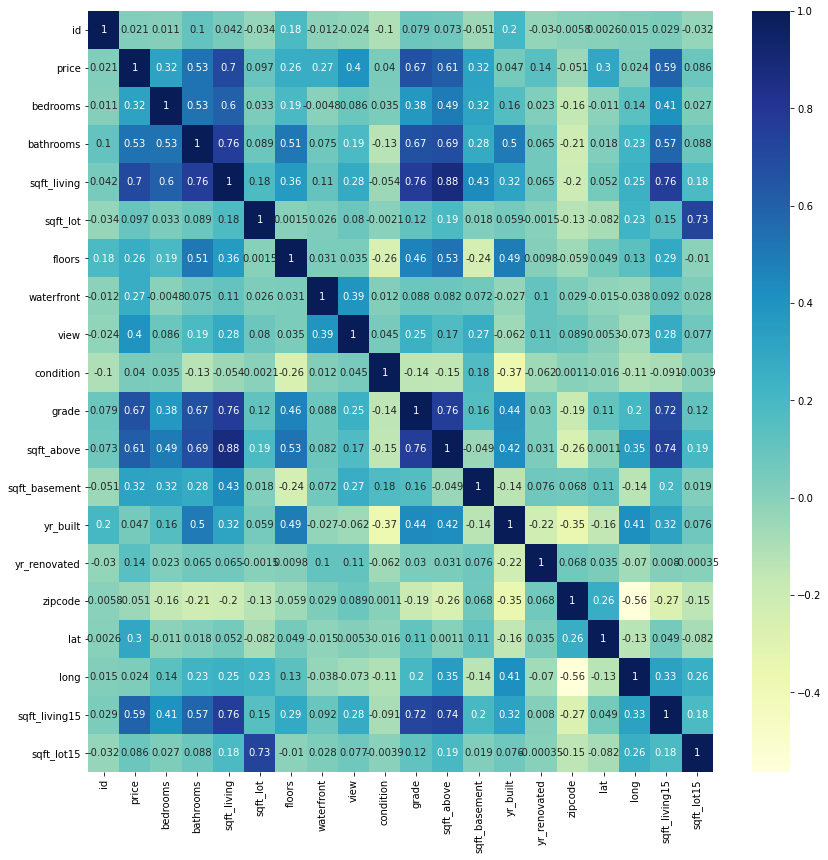

In [4]:
# heatmap을 통한 상관관계 확인

plt.figure(figsize=(14,14))
sns.heatmap(train.corr(), annot=True, cmap="YlGnBu")
plt.show() 

In [5]:
# pairplot을 통한 상관관계 확인 

# sns.pairplot(train)

# 다중공선성 확인

* 회귀문제에서 독립변수들의 관계에서 다중공선성이 발견되면 다중공선성이 있는 feature중 하나를 선택해서 없애야한다. 모델의 성능을 떨어뜨리는 원인이 된다.


* VIF Factor가 10 이상이면 다중공선성 

In [6]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

y0, X0 = dmatrices('price ~ +bedrooms+bathrooms+sqft_living+sqft_lot+floors+waterfront+view+condition+grade+sqft_above+sqft_basement+yr_built+yr_renovated+zipcode+lat+long+sqft_living15+sqft_lot15', train, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X0.values, i) for i in range(X0.shape[1])]
vif['features'] = X0.columns
vif

C:\Users\wjs54\.conda\envs\ml\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,4.635144e+06,Intercept
1,1.722306e+00,bedrooms
2,3.378764e+00,bathrooms
3,inf,sqft_living
4,2.163822e+00,sqft_lot
5,2.028820e+00,floors
6,1.192414e+00,waterfront
7,1.411120e+00,view
8,1.256702e+00,condition
9,3.400942e+00,grade


# 데이터 정제화

In [7]:
# train['date']에서 년월일T000000에서 일T000000제거

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

In [8]:
# train에서 y(taget 지정) 및 제거

y = train['price']
del train['price']

In [9]:
# 나중에 submission.csv 사용 
# sub_id = train['id'][train_len:]

# 필요없는 train['id'] 제거
# index와 중복되며 있으면 다중공선성 문제 발생 또한 여기서는 별다른 의미 없음
del train['id']

In [10]:
# test['date']에서 년월일T000000에서 일T000000제거

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

<AxesSubplot:>

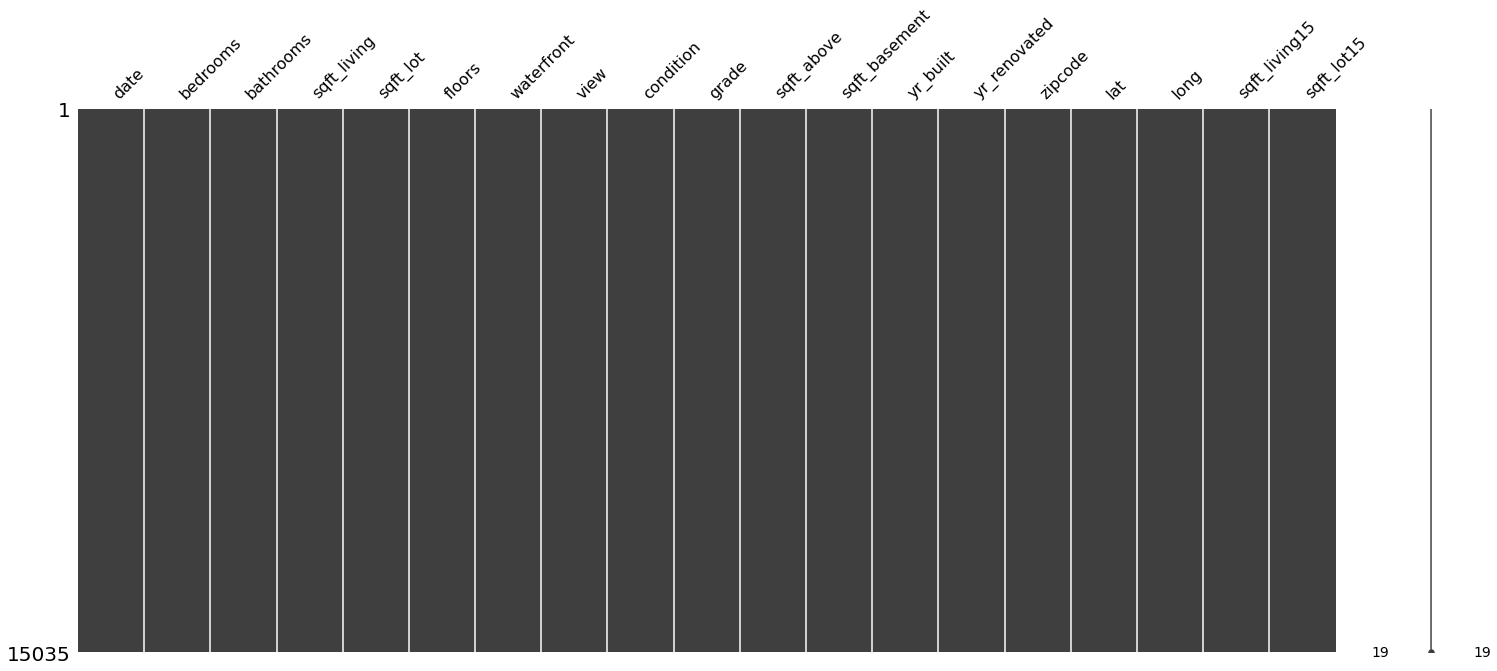

In [11]:
# 누락된 값 확인

msno.matrix(train)

In [12]:
# y 값을 정규분포로 만들기 위해 log1p 사용

y = np.log1p(y)

In [13]:
# rmse
# expm1을 사용하는 이유는 y값에 적용한 log1p를 돌려놓기 위함.

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [14]:
# 모델 정의

random_state=2020        

# baseline model
regr = LinearRegression(normalize=True)
svr = SVR(C=1.0, epsilon=0.2)
lsvr = LinearSVR(random_state=random_state, tol=1e-5)

dtr = DecisionTreeRegressor(random_state=random_state)
etr = ExtraTreeRegressor(random_state=random_state)

# ensemble, boosting, bagging model
bgr = BaggingRegressor(base_estimator=None, n_estimators=30, random_state=random_state) # None = Dicision_tree
adr = AdaBoostRegressor(learning_rate=0.05, random_state=random_state, n_estimators=100)
hgbr = HistGradientBoostingRegressor(learning_rate=0.05, max_depth=10, random_state=random_state)
cbr = CatBoostRegressor(iterations=700, verbose=False, random_state=random_state)

# 아래는 기존 노드의 모델에서 성능 다시 셋팅
gboost = GradientBoostingRegressor(loss='huber', 
                                   n_estimators=3000, 
                                   learning_rate=0.05, 
                                   max_depth=10, 
                                   max_features='sqrt', 
                                   min_samples_leaf=15, 
                                   min_samples_split=10,
                                   random_state=random_state)
xgboost = XGBRegressor(n_estimators=700, max_depth=10, objective ='reg:squarederror', n_jobs=-1, random_state=random_state)
lightgbm = LGBMRegressor(objective='regression', learning_rate=0.05, n_estimators=700, max_depth=10, n_jobs=-1, random_state=random_state)
rdforest = RandomForestRegressor(max_depth=10, n_jobs=-1, verbose=0, random_state=random_state)

# Voting ( boosting model Voting / random Voting)
voting1 = VotingRegressor(estimators=[('adr',adr),('hgbr',hgbr),('lgbr',lightgbm),('xgbr',xgboost),('cbr',cbr)])
voting2 = VotingRegressor(estimators=[('etr',etr),('rfr',rdforest),('bgr',bgr)]) 

# Average Blending 1, lms node base model
model1 = [{'model':gboost, 'name':'GradientBoost'},
           {'model':xgboost, 'name':'XGBRegressor'},
           {'model':lightgbm, 'name':'LGBMRegressor'}]

# Average Blending 2, Voting model
model2 = [{'model':voting1, 'name':'Voting1'},
          {'model':voting2, 'name':'Voting2'}]

# Average Blending 3, boosting model random
model3 = [{'model':hgbr, 'name':'HistGradientBoosting'},
          {'model':lightgbm, 'name':'LGBMRegressor'},
          {'model':xgboost, 'name':'XGBRegressor'},
          {'model':cbr, 'name':'CatBoostRegressor'}]

# Average Blending 4
model4 = [{'model':hgbr, 'name':'HistGradientBoosting'},
          {'model':lightgbm, 'name':'LGBMRegressor'},
          {'model':cbr, 'name':'CatBoostMRegressor'}]

# Average Blending 5, good performance model
model5 = [{'model':xgboost, 'name':'XGBRegressor'},
          {'model':lightgbm, 'name':'LGBMRegressor'},
          {'model':cbr, 'name':'CatBoostMRegressor'}]

models = [regr, svr, gboost, xgboost, lightgbm, rdforest, voting1, voting2, dtr, etr, bgr, adr, hgbr, cbr]

# 데이터 나누기

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

In [16]:
print(train.shape)
print(y.shape)

(15035, 19)
(15035,)


# Baseline model 결과

In [17]:
def get_scores(models, train, y):
    # 답안 작성
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df


get_scores(models, train, y)

,RMSE
SVR,287055.791923
AdaBoostRegressor,198458.098336
ExtraTreeRegressor,187045.205381
LinearRegression,178451.358924
DecisionTreeRegressor,177191.527507
RandomForestRegressor,130885.418223
BaggingRegressor,126569.520359
VotingRegressor,126569.444735
HistGradientBoostingRegressor,120914.049038
LGBMRegressor,109603.233362


# Average Blending 결과

In [18]:
def ab_score(models, train, y):
    df = {}
    print('Models')
    
    for model in models:
        model_name = model['model'].__class__.__name__ 
        print(model_name)
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model['model'].fit(X_train, y_train)
        
        y_pred = np.column_stack([model['model'].predict(X_test) for model in models])
        y_pred = np.mean(y_pred, axis=1)
        
        df['Average_Blending'] = rmse(y_test, y_pred)   
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df

In [19]:
models_ = [model1, model2, model3, model4, model5]

for model_ in models_:
    print('='*30)
    print(ab_score(model_, train, y))

Models
GradientBoostingRegressor
XGBRegressor
LGBMRegressor
                           RMSE
Average_Blending  105290.382004
Models
VotingRegressor
VotingRegressor
                           RMSE
Average_Blending  116981.096026
Models
HistGradientBoostingRegressor
LGBMRegressor
XGBRegressor
CatBoostRegressor
                           RMSE
Average_Blending  106260.751392
Models
HistGradientBoostingRegressor
LGBMRegressor
CatBoostRegressor
                           RMSE
Average_Blending  107895.148619
Models
XGBRegressor
LGBMRegressor
CatBoostRegressor
                           RMSE
Average_Blending  103554.421755


# Stacking ensemble 결과

In [20]:
# define dataset
X, y = X_train, y_train

# define the base models
level0 = list()
level0.append(('gboost', gboost))
level0.append(('xgboost', xgboost))
level0.append(('lightgbm', lightgbm))
# define meta learner model
level1 = cbr
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5, verbose=1)
# fit the model on all available data
model.fit(X, y)

# make a prediction for one example
yhat = model.predict(X_test)
print('Predicted Value: ', yhat)
print('-'*30)

# RMSE
reg_stack_rmse = rmse(y_test, yhat)
print('RMSE : ', reg_stack_rmse)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.5s finished


Predicted Value:  [13.24987864 12.01612732 12.5506951  ... 13.21764838 12.33960888
 13.22479439]
------------------------------
RMSE :  110664.00906216622


# Stacking ensemble 모듈화
* 시간이 오래걸려서 주석처리

In [21]:
# # dataset 
# # model = gboost, xgboost, lightgbm, rdforest
# def get_dataset():
#     X_, y_ = X_train, y_train
#     return X_, y_

# # get a stacking ensemble of models
# # define the base models
# def get_stacking():
#     level0 = list()
#     level0.append(('gboost', gboost))
#     level0.append(('xgboost', xgboost))
#     level0.append(('lightgbm', lightgbm))
#     level0.append(('rdforest', rdforest))
#     # define meta learner model
#     level1 = cbr # catboost
#     # define the stacking ensemble
#     model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
#     return model

# def get_models():
#     models = dict()
#     models['gboost'] = gboost
#     models['xgboost'] = xgboost
#     models['lightgbm'] = lightgbm
#     models['rdforest'] = rdforest
#     models['Stacking'] = get_stacking()
#     return models

# def evaluate_model(model, X_, y_):
#     cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_state)
#     scores = cross_val_score(model, X_, y_, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
#     return scores

# X_, y_ = get_dataset()

# models = get_models()

# results, names = list(), list()
# for name, model in models.items():
#     scores = evaluate_model(model, X_, y_)
#     results.append(scores)
#     names.append(name)
#     print('>%s %.3f (%.3f) (RMSE: %.4f)' % (name, mean(scores), std(scores), rmse(scores)))
#     print('='*30)

# GridSearch

In [22]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [23]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

'''
# 기존 코드에 적용되는 것 : rfr, gbr, lgbr, xgbr
# 기존 코드에 적용안되는 것 : dtr, etr, bgr, adr, hgbr, hgbr, cbr

각 모델의 param 값을 찾아서 param_grid를 변경해야 함.
'''
print('-'*50)
print('RandomForest')
print('-'*50)
my_GridSearch(rdforest, X_train, y_train, param_grid)

--------------------------------------------------
RandomForest
--------------------------------------------------
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:   10.4s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.035215,0.187657
2,10,50,-0.035376,0.188084
0,1,50,-0.180198,0.424497
1,1,100,-0.181149,0.425616


In [24]:
print('-'*50)
print('GradientBoost')
print('-'*50)
my_GridSearch(gboost, X_train, y_train, param_grid)

--------------------------------------------------
GradientBoost
--------------------------------------------------
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:   11.5s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.028917,0.170050
2,10,50,-0.035383,0.188105
1,1,100,-0.081545,0.285561
0,1,50,-0.120084,0.346531


In [25]:
print('-'*50)
print('lightGradientBosst')
print('-'*50)
my_GridSearch(lightgbm, X_train, y_train, param_grid)

--------------------------------------------------
lightGradientBosst
--------------------------------------------------
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    1.0s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.029183,0.170830
2,10,50,-0.036962,0.192255
1,1,100,-0.073825,0.271708
0,1,50,-0.104434,0.323162


In [26]:
print('-'*50)
print('XGBoost')
print('-'*50)
my_GridSearch(xgboost, X_train, y_train, param_grid)

--------------------------------------------------
XGBoost
--------------------------------------------------
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    7.9s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.028158,0.167804
2,10,50,-0.034917,0.186860
1,1,100,-0.054709,0.233900
0,1,50,-0.077415,0.278236


In [27]:
print('-'*50)
print('CatBoost')
print('-'*50)

cbr_param_grid = {
    'iterations': [10, 30, 50, 100],
    'learning_rate': [1, 5, 10, 20],
    'depth':[1, 2, 4, 6]
}

my_GridSearch(cbr, X_train, y_train, param_grid=cbr_param_grid)

--------------------------------------------------
CatBoost
--------------------------------------------------
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 320 out of 320 | elapsed:   23.2s finished
C:\Users\wjs54\.conda\envs\ml\lib\site-packages\sklearn\model_selection\_search.py:813: RuntimeWarning: overflow encountered in square
  array_stds = np.sqrt(np.average((array -


,depth,iterations,learning_rate,score,RMSLE
28,2,100,1,-3.116078e-02,1.765242e-01
44,4,100,1,-3.136879e-02,1.771124e-01
40,4,50,1,-3.174249e-02,1.781642e-01
36,4,30,1,-3.333646e-02,1.825827e-01
56,6,50,1,-3.339142e-02,1.827332e-01
...,...,...,...,...,...
30,2,100,10,-7.589393e+189,8.711712e+94
15,1,100,20,-3.959164e+254,1.989765e+127
63,6,100,20,-4.637373e+254,2.153456e+127
47,4,100,20,-5.793297e+254,2.406927e+127


In [28]:
print('-'*50)
print('HGBoost')
print('-'*50)
'''
'learning_rate': 기본값 = 0.1
'max_iter': 기본값 = 100 
'max_depth': 기본값 = 31, None이면 제한없음
'min_samples_leaf : 기본값 = 없음
'l2_regularization : 기본값 = 0, 0이면 사용안함
'max_bins': 기본값 = 255, 255 이하여야 함.


'''
hgb_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
}

my_GridSearch(hgbr, X_train, y_train, param_grid=hgb_param_grid)

--------------------------------------------------
HGBoost
--------------------------------------------------
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    4.1s finished


,learning_rate,score,RMSLE
0,0.10,-0.027500,0.165831
1,0.05,-0.029111,0.170618
2,0.01,-0.080795,0.284245


In [29]:
print('-'*50)
print('AdaBoost')
print('-'*50)
'''

'''
adb_param_grid = {
    'learning_rate': [1, 0.1, 0.05, 0.01, 0.001],
}

my_GridSearch(adr, X_train, y_train, param_grid=adb_param_grid)

--------------------------------------------------
AdaBoost
--------------------------------------------------
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  25 out of  25 | elapsed:   17.2s finished


,learning_rate,score,RMSLE
0,1.000,-0.066209,0.257311
1,0.100,-0.069053,0.262780
2,0.050,-0.071978,0.268287
3,0.010,-0.085745,0.292822
4,0.001,-0.090199,0.300331


# 참고

__1차 시도__
* 상관관계 분석을 통해 다음과 같은 방법을 시도하였음
 * 다중공선성이 있는 것으로 보여지는 3개의 feature를 삭제 하였으나 p-value를 확인하지 않고 지웠음.
   * sqft_living, sqft_above, sqft_basement
   * 다중 공선성 분석 중 10이상의 값이 나왔음(inf, 무한대)
 * 삭제해서 전체적으로 확인해본 결과 오히려 RMSE가 떨어졌고 3개의 feature는 유의미한 feature로 판단되었으며 지워서는 안됨을 확인하였음.
   * p-value 값을 확인하지 않았지만 유의미한 값임을 알 수 있었음.
 * 기존의 노드에서 log1p로 변환했던 5개의 feature는 다시 적용했을 때 성능이 많이 떨어져 변환하지 않고 그대로 사용 

__2차 시도__
* 상관관계에서 변수간의 영향이 없어보이는 feature 4개를 삭제하였으나 RMSE가 떨어짐
 * zipcode, lat, long, sqft_lot15

__3차 시도__
* GridSearchCV를 시도하여 각 모델에 setting
 * GridSearch를 적용한 모델도 있지만 대부분은 random하게 setting
 * GridSearch를 만들 때 다양한 변수를 넣고 실행하면 최적의 값을 찾는 수행시간도 오래걸림
 * 모델별 다양한 변수를 넣기 위해서는 모델별로 인자값이 다르기 때문에 찾는 시간이 오래 걸림
 * 모델별로 공통된 인자 값 위주로 넣었으며 세부적인 인자 값을 setting 할 때 보다 성능이 안좋음

__4차 시도__
* average blending 만든 후 테스트
 * 기존의 노드의 코드를 활용하여 함수 재작성

__5차 시도__
* stacking average model(== stacking ensemble) 만든 후 테스트
 * regression stacking 예시를 구글링하여 참고하였음
 * 코드 수행시간이 매우 오래 걸림.

# 추가
* 기존 노드에서 진행했던 방식에서 데이터를 크게 건들지 않았음
 * 만졌을 때 오히려 성능이 떨어졌음.
 * 기존 노드에서 log1p를 통해 feature들을 정규분포로 만들었는데 생략하였음(오히려 성능이 안좋아짐)
* Average Blending과 Stacking Average Blending은 오히려 성능이 baseline catboost보다 더 안좋게 나옴.
 * RandomForest 때문에 그럴 것이라고 해서 실제로 RF를 없애고 해도 성능은 비슷했음(why?)
* baseline model catboost로 제출 예정

# 참고
* [Stacking Average Model(==Stacking ensemble) regression](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/)
* [sklearn cross_val_score score setting](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
* [sklearn StackingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn-ensemble-stackingregressor)
* [stacking 관련 참고글](https://statkclee.github.io/model/model-ensemble.html)
* [수비니움 캐글 그랜드마스터 참고](https://www.kaggle.com/subinium/subinium-tutorial-house-prices-advanced)

# 제출

In [35]:
# sample_submission.csv 파일 가져오기
# reg_stack_rmse(average blending predictions)
cbr.fit(X_train, y_train)
y_pred = cbr.predict(X_test)
data_dir = 'C:\\code\\AIFFEL_Project\\E6_data\\'
submission_path = os.path.join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = y_pred
submission_csv_path = '{}/submission_RMSLE.csv'.format(data_dir)
submission.to_csv(submission_csv_path, index=False)
print('save')

ValueError: Length of values (3007) does not match length of index (6468)